# IASA DS CHAMP
## Validating

In [111]:
import matplotlib.pyplot as plt

import numpy as np
import pandas as pd
import seaborn as sns
import shap


import sklearn.metrics as metrics
from xgboost import XGBRegressor

In [112]:
XGB_sub = XGBRegressor()
XGB_sub.load_model("XGB_sub.json")

XGB_ad = XGBRegressor()
XGB_ad.load_model("XGB_ad.json")

XGB_iap = XGBRegressor()
XGB_iap.load_model("XGB_iap.json")

X_valid = pd.read_csv("X_valid.csv")
X_train = pd.read_csv("X_train_high.csv")
y_sub_valid = pd.read_csv("y_sub_valid.csv")
y_ad_valid = pd.read_csv("y_ad_valid.csv")
y_iap_valid = pd.read_csv("y_iap_valid.csv")
y_valid = pd.read_csv("y_valid.csv")

### About metrics
We include all three metrics as you asked, but MAPE can't really be used here because it encounters division by 0 in process, so its values would be extremely large.
Also, we propose to introduce **one more metric**. As stated in the assignment, we predict the company's earnings, so let's see how good our models do exactly that by checking the **difference** between sums of prediction and actual earnings.

In [113]:
def print_metrics(y_v, y_p):
    print("RMSE: ", round(metrics.mean_squared_error(y_v, y_p, squared=False), 5))
    print("MAE: ", round(metrics.mean_absolute_error(y_v, y_p), 5))
    print("MAPE: ", round(metrics.mean_absolute_percentage_error(y_v, y_p), 5))
    print("Difference(%): ", round((abs(y_v.sum() - y_p.sum()) / y_v.sum() * 100)[0], 3))  # error as a percentage of total earnings
    print()


### Testing

In [114]:
# subscriptions
y_XGB_sub_pred = XGB_sub.predict(X_valid)
print_metrics(y_sub_valid, y_XGB_sub_pred)

RMSE:  0.19893
MAE:  0.02051
MAPE:  30845834592703.535
Difference(%):  2.878



In [115]:
# in-app purchases
y_XGB_iap_pred = XGB_iap.predict(X_valid)
print_metrics(y_iap_valid, y_XGB_iap_pred)

RMSE:  1.031
MAE:  0.07141
MAPE:  41232939680257.27
Difference(%):  1.779



In [116]:
# ads
y_XGB_ad_pred = XGB_ad.predict(X_valid)
print_metrics(y_ad_valid, y_XGB_ad_pred)

RMSE:  0.09544
MAE:  0.00793
MAPE:  1823950379615.2788
Difference(%):  0.172



Let's get target as their sum and check the metrics

In [117]:
y_XGB_sum_pred = y_XGB_ad_pred + y_XGB_sub_pred + y_XGB_iap_pred
print("sum vs target metrics: ")
print_metrics(y_valid, y_XGB_sum_pred)

sum vs target metrics: 
RMSE:  1.10296
MAE:  0.08833
MAPE:  12473813582252.072
Difference(%):  1.737



## Interpretation
The models preformed well, both together and separately. Let's see what they paid attention to the most by watching the most important one: XGB_iap.
To do that we'll use SHAP: *a characterizing value of the average marginal contribution among all possible combinations of features*.

In [118]:
X100 = shap.utils.sample(X_train, 100)
explainer = shap.Explainer(XGB_iap.predict, X100)
shap_values = explainer(X_train)

Permutation explainer: 413it [01:28,  4.10it/s]                         


This is how it works on the rows where company got a lot of money from players.
Here, for example, model gave a lot of attention on chapters finished to day 7, tickets spent and income from subscriptions on day 3.

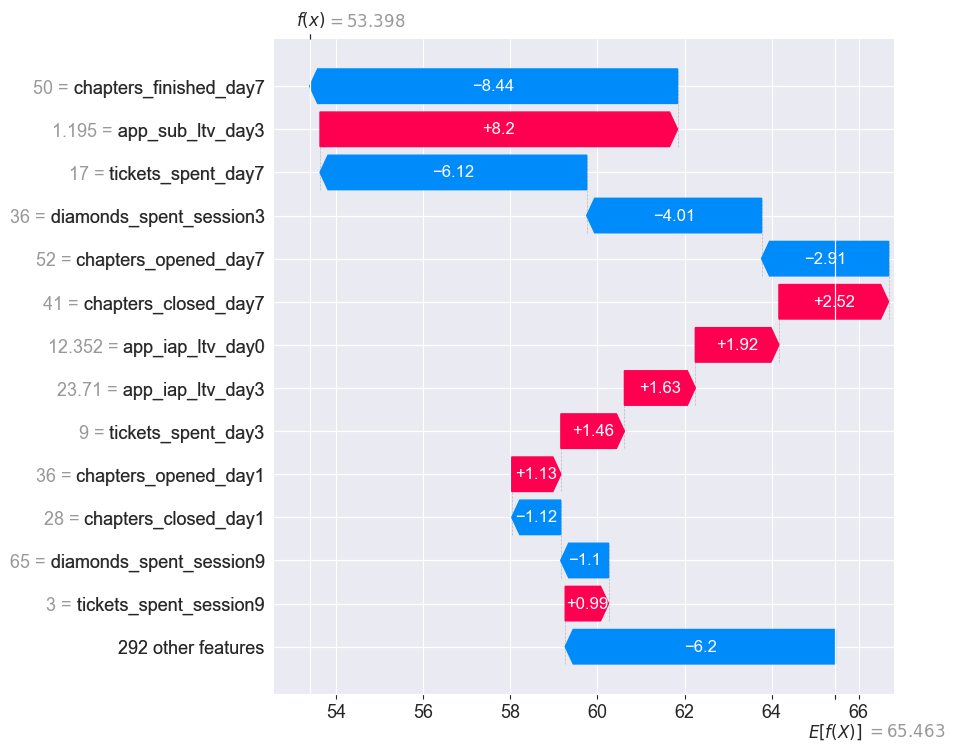

In [119]:
shap.plots.waterfall(shap_values[42], max_display=14)

And this is a visualisation of the model working on everyone, whose total target was > 50.
Here we can see that, for example, the higher the amount of finished chapters to day 7 - the more likely the model is to predict a large value for that player and vice-versa for the chapters closed to day 3 or day 7.

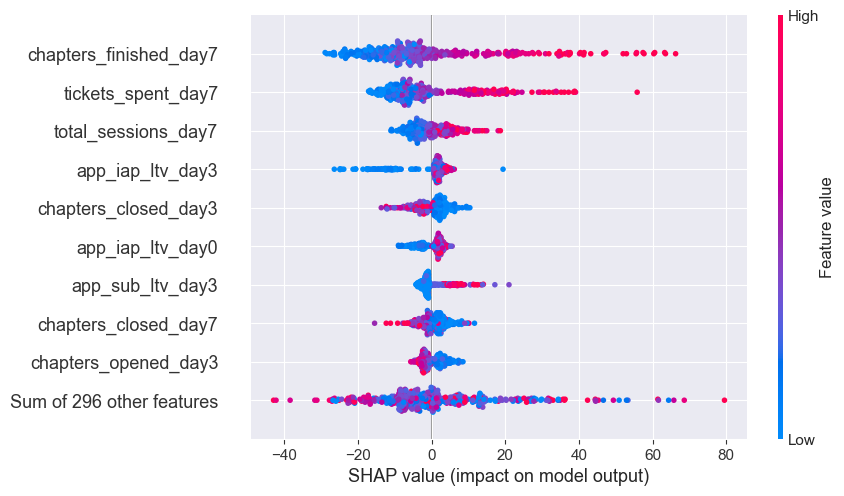

In [120]:
shap.plots.beeswarm(shap_values)

Seems like the amount of chapters finished on day 7 is the most important feature for this XGB.
And this is how exactly 'chapters_finished_day7' correlates with the model prediction.

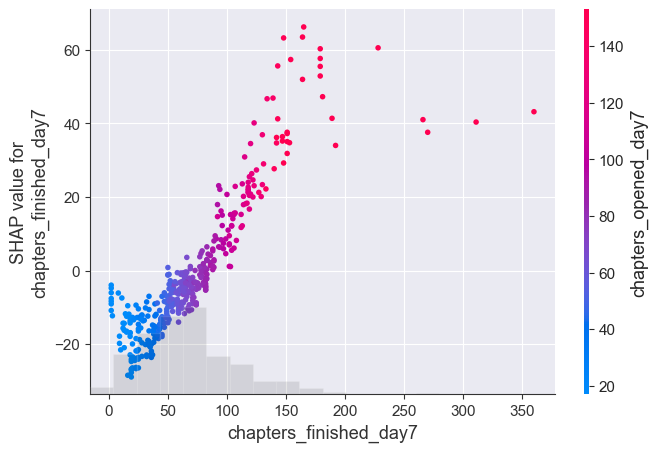

In [121]:
shap.plots.scatter(shap_values[:,"chapters_finished_day7"], color=shap_values)

Let's see what thinks the other model - the one that's predicting income from subscriptions.

In [122]:
explainer = shap.Explainer(XGB_sub.predict, X100)
shap_values = explainer(X_train)

Permutation explainer: 413it [01:34,  3.86it/s]                         


42nd user again. As expected, the income from subscriptions on 3rd day matter the most, and also if the player came back on the 7th day - it's a good sign for our model.

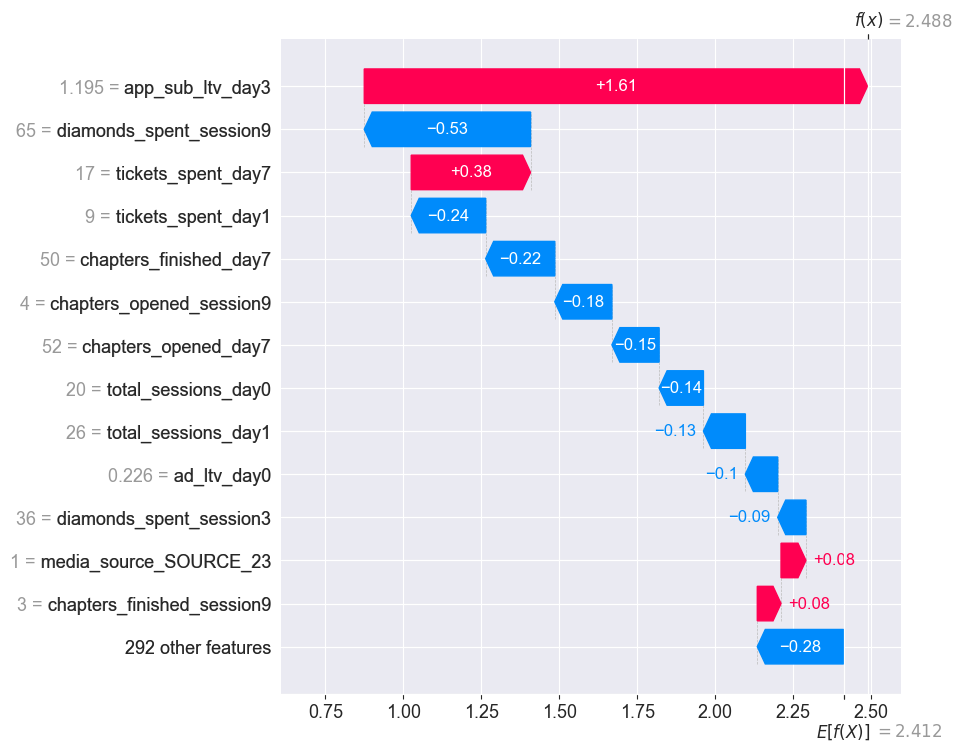

In [123]:
shap.plots.waterfall(shap_values[42], max_display=14)

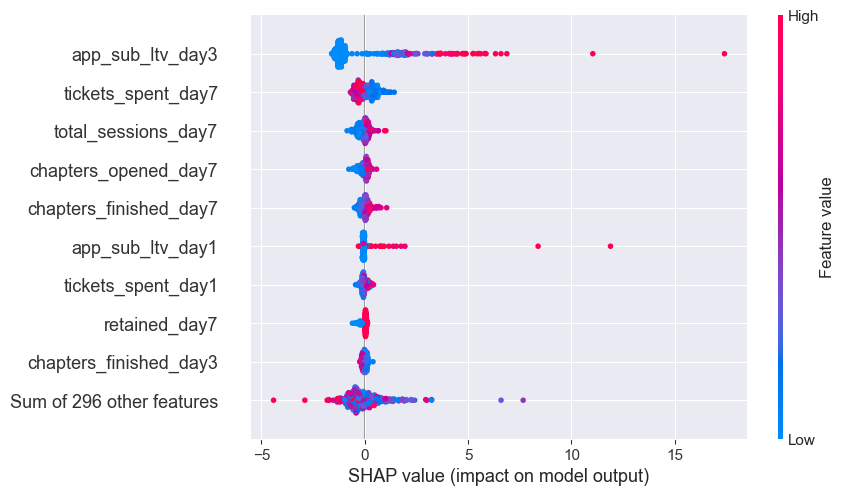

In [124]:
shap.plots.beeswarm(shap_values)

Lastly, let's look on ad income.

In [125]:
explainer = shap.Explainer(XGB_ad.predict, X100)
shap_values = explainer(X_train)

Permutation explainer: 413it [01:24,  4.35it/s]                         


As expected, it depends on the amount of sessions on day 3 and day 7.

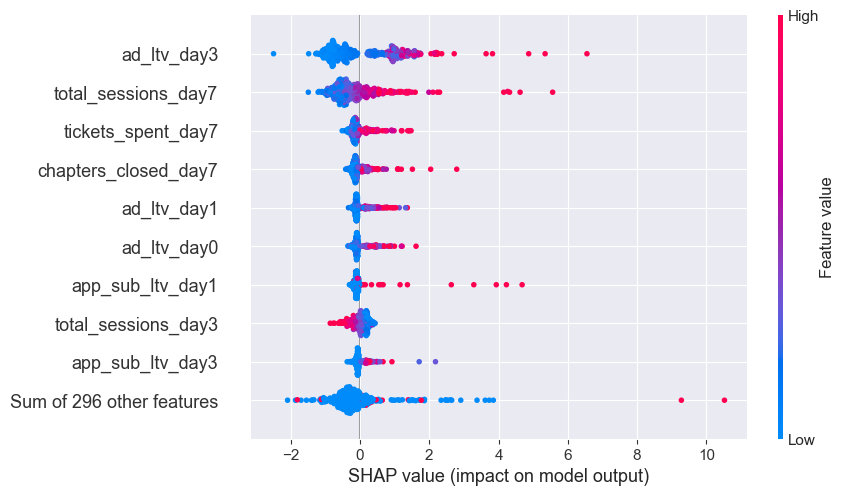

In [126]:
shap.plots.beeswarm(shap_values)

Thank you for reading!